In [5]:
# Step 2: Customer Segmentation Preparation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
file_path = '../../data/cleaned_retail_data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
df.head()

Shape: (779425, 9)

Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'InvoiceMonth']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12


In [6]:
# Ensure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Choose snapshot date (last date in data + 1 day)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'Price': 'sum'                                            # Monetary (raw)
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print("\nRFM sample:")
print(rfm.head())


RFM sample:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326         12    207.40
1     12347.0        2          8    554.57
2     12348.0       75          5    193.10
3     12349.0       19          4   1480.44
4     12350.0      310          1     65.30


In [8]:
# Step 3: Customer Segmentation using K-Means

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Normalize the RFM values
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)

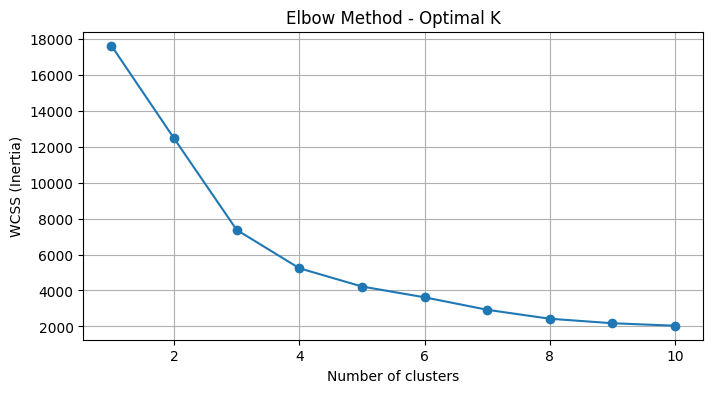

In [9]:
# 2. Elbow method to find optimal number of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

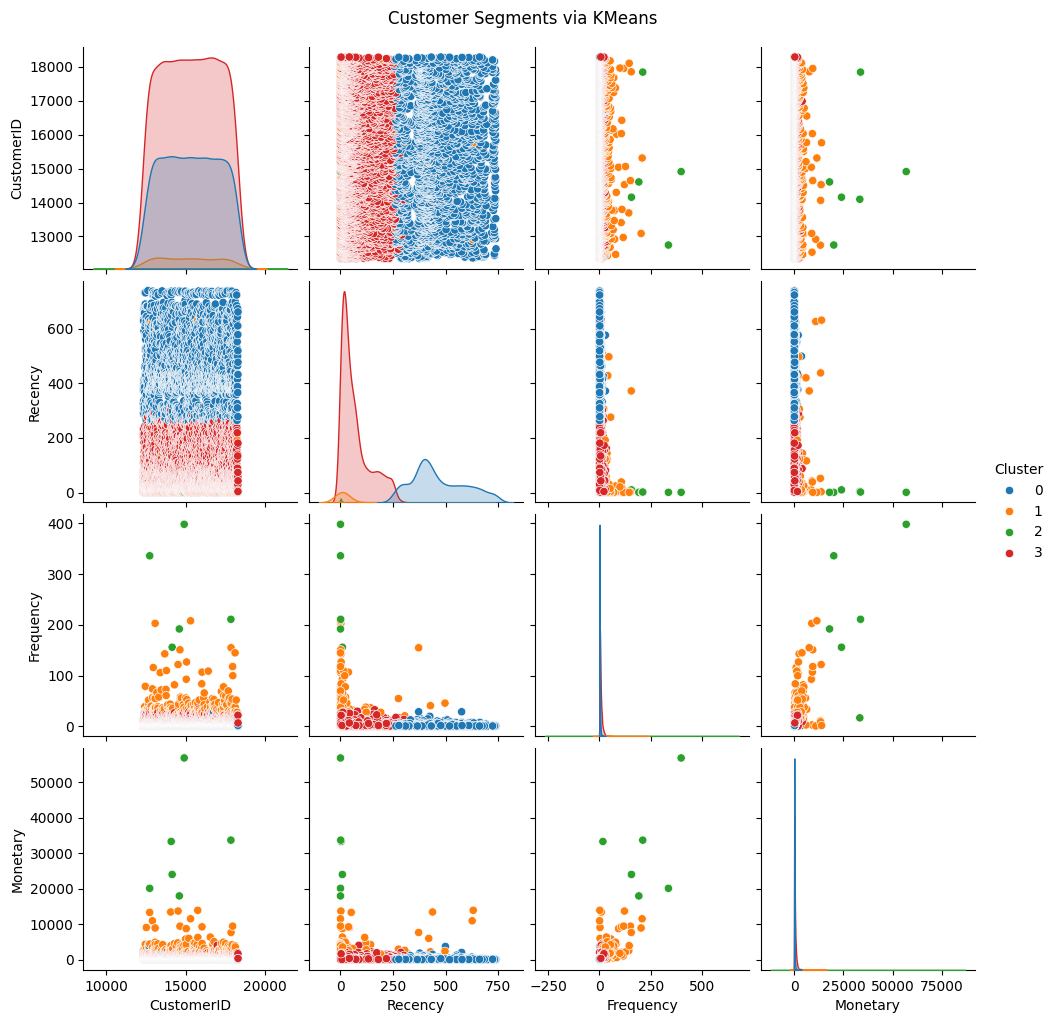

In [10]:
# 3. Apply KMeans with chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 4. Visualize clusters
sns.pairplot(rfm, hue='Cluster', palette='tab10')
plt.suptitle("Customer Segments via KMeans", y=1.02)
plt.show()

In [11]:
# Summary of each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(1)

print("📋 Cluster Summary:\n")
print(cluster_summary)

📋 Cluster Summary:

         Recency  Frequency  Monetary  Count
Cluster                                     
0          465.2        2.2     135.4   1970
1           34.2       45.3    3147.4    191
2            3.2      218.3   31006.2      6
3           70.2        6.1     392.0   3711


In [13]:
# Save clustered data to CSV
rfm.to_csv('../../data/rfm_customer_segments.csv', index=False)
print("✅ RFM data with clusters saved as rfm_customer_segments.csv")

✅ RFM data with clusters saved as rfm_customer_segments.csv


In [18]:
# Label clusters with custom segment names
def assign_segment(row):
    if row['Cluster'] == 1:
        return 'High-Value Loyal'
    elif row['Cluster'] == 3:
        return 'Mid-Value'
    elif row['Cluster'] == 0:
        return 'Low-Value Inactive'
    elif row['Cluster'] == 2:
        return 'Outlier VIP'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Show sample with new labels
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']].head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,326,12,207.40,0,Low-Value Inactive
1,12347.0,2,8,554.57,3,Mid-Value
2,12348.0,75,5,193.10,3,Mid-Value
3,12349.0,19,4,1480.44,3,Mid-Value
4,12350.0,310,1,65.30,0,Low-Value Inactive


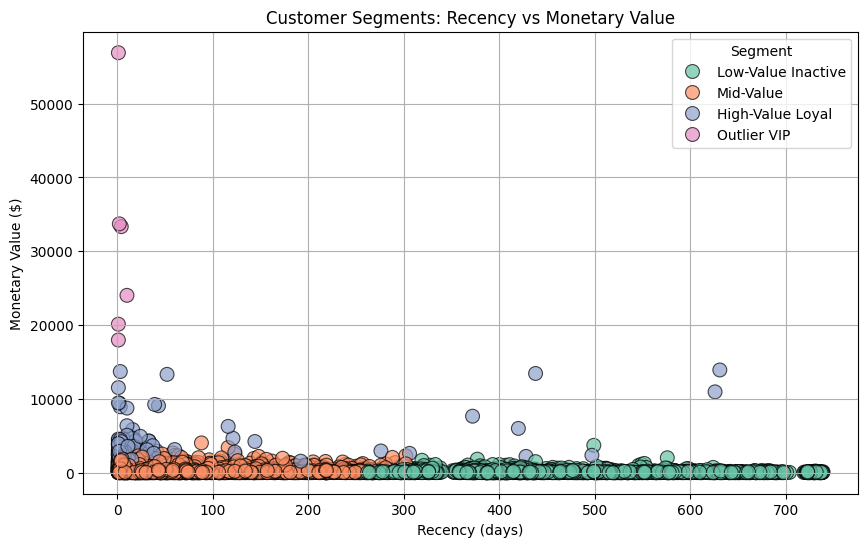

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm,
    x='Recency', y='Monetary',
    hue='Segment',
    palette='Set2',
    s=100,
    alpha=0.7,
    edgecolor='k'
)
plt.title('Customer Segments: Recency vs Monetary Value')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value ($)')
plt.grid(True)
plt.show()

In [20]:
# Save the final segmented data
rfm.to_csv('../../data/segmented_customers.csv', index=False)
print("✅ Segmented customer data saved as '../data/segmented_customers.csv'")

✅ Segmented customer data saved as '../data/segmented_customers.csv'


In [21]:
# Top 10% customers by Monetary value
top_customers = rfm[rfm['Monetary'] >= rfm['Monetary'].quantile(0.90)]
top_customers = top_customers.sort_values(by='Monetary', ascending=False)

print("🔝 Top 10 Customers by Monetary Value:")
print(top_customers[['CustomerID', 'Monetary', 'Frequency', 'Recency', 'Cluster']].head(10))

🔝 Top 10 Customers by Monetary Value:
      CustomerID  Monetary  Frequency  Recency  Cluster
2538     14911.0  56885.65        398        1        2
5433     17841.0  33704.95        211        2        2
1731     14096.0  33332.45         17        4        2
1789     14156.0  24025.74        156       10        2
400      12748.0  20115.95        336        1        2
2237     14606.0  17972.54        192        1        2
3382     15760.0  13916.34          2      631        1
2158     14527.0  13704.51        122        3        1
1698     14063.0  13443.55          9      438        1
396      12744.0  13322.50         11       52        1


In [22]:
# Assign business strategy labels based on cluster
def tag_customer(row):
    if row['Cluster'] == 1:
        return 'Loyal High-Value'
    elif row['Cluster'] == 2:
        return 'VIP Outlier'
    elif row['Cluster'] == 0:
        return 'At-Risk'
    elif row['Cluster'] == 3:
        return 'Potential'
    else:
        return 'Other'

rfm['SegmentTag'] = rfm.apply(tag_customer, axis=1)

# Preview sample tagged customers
rfm[['CustomerID', 'Cluster', 'SegmentTag']].sample(10)

,CustomerID,Cluster,SegmentTag
5267,17674.0,3,Potential
378,12726.0,3,Potential
515,12863.0,3,Potential
1281,13643.0,3,Potential
3101,15479.0,0,At-Risk
2880,15256.0,3,Potential
414,12762.0,3,Potential
1883,14250.0,3,Potential
5529,17937.0,3,Potential
4679,17075.0,3,Potential


## 🎯 Retention Strategy by Segment

| Segment            | Strategy |
|--------------------|----------|
| **VIP Outlier**     | White-glove service, personal concierge, exclusive perks |
| **Loyal High-Value**| Loyalty programs, early access to new arrivals |
| **Potential**       | Email nurturing, onboarding offers |
| **At-Risk**         | Re-engagement campaigns, time-sensitive offers |

/Users/arnavsrivastava/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.



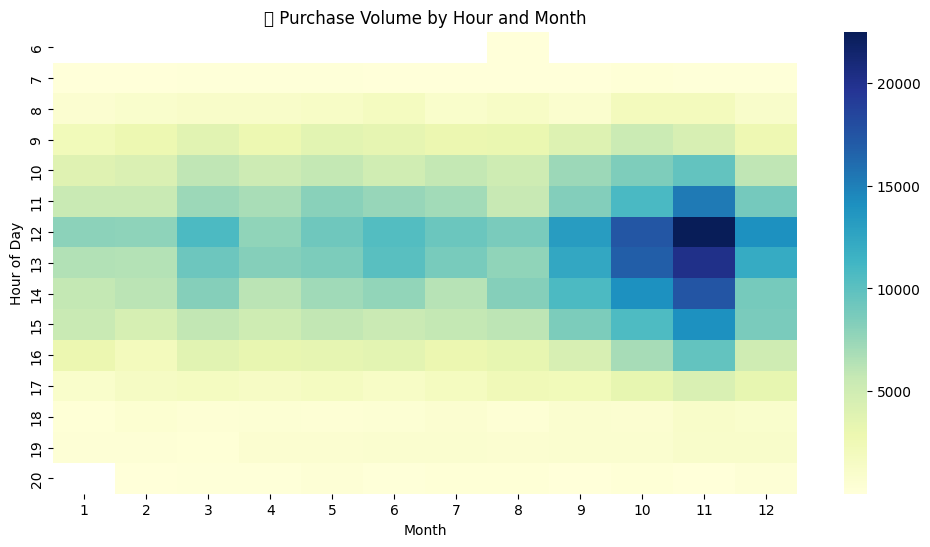

In [23]:
# Analyze purchase patterns by hour and month
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month

heatmap_data = df.pivot_table(index='Hour', columns='Month', values='Invoice', aggfunc='count')

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('🕒 Purchase Volume by Hour and Month')
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.show()

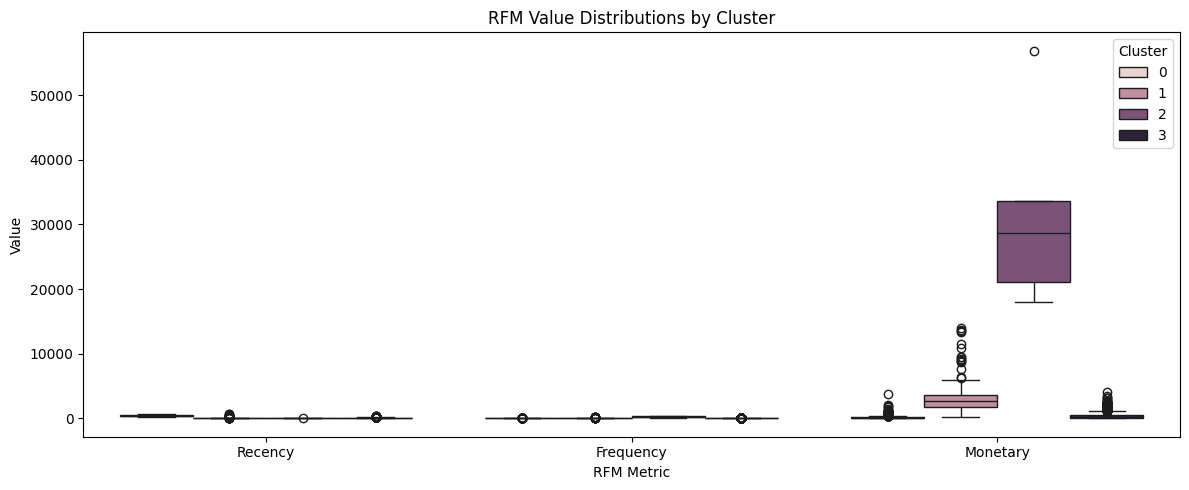

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
rfm_melted = rfm.melt(id_vars=['Cluster'], value_vars=['Recency', 'Frequency', 'Monetary'], var_name='Metric', value_name='Value')
sns.boxplot(x='Metric', y='Value', hue='Cluster', data=rfm_melted)
plt.title('RFM Value Distributions by Cluster')
plt.xlabel('RFM Metric')
plt.ylabel('Value')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

/var/folders/nt/w5ryn4193mzd8n50y8yjpgkh0000gn/T/ipykernel_34012/2872736144.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




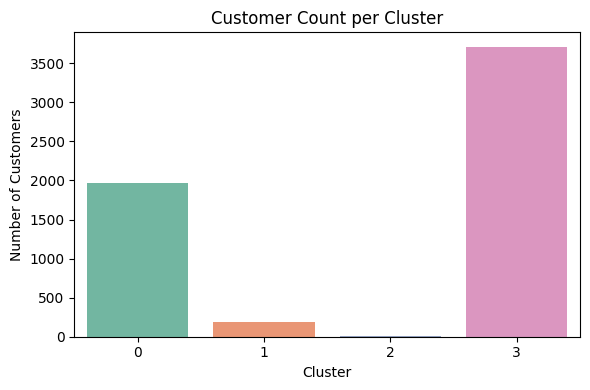

In [27]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x='Cluster', palette='Set2')
plt.title('Customer Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

## 💡 Customer Segmentation Summary (RFM + KMeans)

We performed RFM (Recency, Frequency, Monetary) analysis on the cleaned retail dataset and applied K-Means clustering to segment customers into distinct behavioral groups. Based on the Elbow Method, the optimal number of clusters was **4**. The segments show significant variation in purchase behavior.

### 📊 Cluster Interpretation:
- **Cluster 0**: Dormant customers – high recency, low frequency and spending.
- **Cluster 1**: Loyal, frequent buyers – recent, frequent, and high spenders.
- **Cluster 2**: High-value outliers – extremely high frequency and spending.
- **Cluster 3**: Moderate-value customers – moderate frequency and spend, recent activity.

### ✅ Deliverables:
- Elbow plot for cluster optimization
- RFM cluster visualization (pairplot)
- 3D interactive scatter plot (optional)
- Final CSV: `rfm_customer_segments.csv` with labeled clusters